# Gaussian Processes for Orientation Preference Maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from opm import make_opm, plot_opm, plot_amplitude_map, calculate_map
from opm.response import response, create_stimuli, compute_responses
from opm.gp.kernels import mexican_hat_kernel
from opm.gp.helpers import get_2d_indices
from opm.gp import GaussianProcessOPM
from opm.gp.prior import prior_covariance
from opm.gp.match_radial_component import radial_component, match_radial_component

## Ground truth map

For computational simplicity, we create an OPM of lower dimensionality. Additionally, we need the (x,y) indices for every pixel.

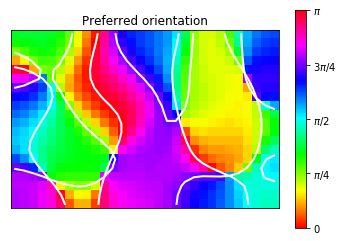

In [2]:
size = (20,30)

n = size[0] * size[1]
d = 3

# ground truth opm
m = make_opm(size=size, sigma=3., k=2., alpha=2.)

f, ax = plot_opm(m)

plt.show()

idx = get_2d_indices(size)

## Responses
The responses are computed exactly the same way as before.

In [3]:
# compute responses
contrasts = [1.]
orientations = [i * np.pi / 4 - np.pi/2 for i in range(4)]
repetitions = 16

V = create_stimuli(contrasts, orientations, repetitions)

# number of trials
N_cond = V.shape[0]
N = N_cond * V.shape[1]

R = compute_responses(m, contrasts, orientations, repetitions, sigma=0.1)

V_cov = V.reshape((N,d)).T @ V.reshape((N,d))
np.allclose(V_cov, N / 2 * np.eye(d))
(V_cov).round(5)

array([[32.,  0., -0.],
       [ 0., 32., -0.],
       [-0., -0., 32.]])

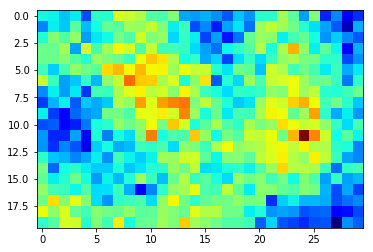

In [4]:
R.shape
res = R.reshape((N,-1))
plt.imshow(res[1].reshape(size), cmap='jet')

In [5]:
V.shape

(4, 16, 3)

## Prior covariance
For the prior covariance, a Mexican hat kernel (approximated by a difference of Gaussians) is used:

$$
K_{prior}(x, x') = \sum_{a,b=1}^{2} \frac{\alpha_a \alpha_b}{2 \pi (\alpha_a^2 + \alpha_b^2}) \, exp(-\frac{1}{2} (\frac{||x - x'||^2}{\alpha_a^2 + \alpha_b^2}))
$$

The kernel has three parameters:
- $\sigma$, the standard deviation of the positive Gaussian ($\sigma_1$)
- $k$, the scaling factor for the standard deviation of the negative Gaussian w.r.t. that of the positive Gaussian ($\frac{\sigma_2}{\sigma_1}$)
- $\alpha$, an overall scaling factor ($\alpha_1 = -\alpha_2$)



Here, this kernel function is visualized for the one-dimensional case with two different parameter settings.

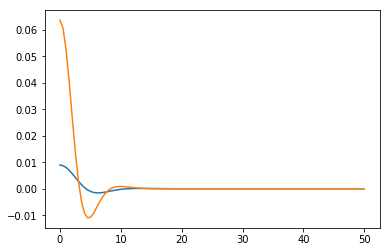

In [6]:
xx = np.linspace(0, 50, 100)[:,np.newaxis]
plt.plot(xx, mexican_hat_kernel(xx, 0, sigma=2., k=2., alpha=1.))
plt.plot(xx, mexican_hat_kernel(0, xx, sigma=3., k=0.5, alpha=2.))
plt.show()


The prior covariance matrix $K$ for a set of indices is now computed as the kernel function between every combination of indices. The spectrum of eigenvalues of $K$ quickly drops off. There are however some negative eigenvalues, since $K$ is not positive definite

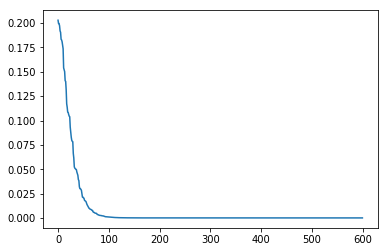

In [7]:
K = prior_covariance(idx, kernel=mexican_hat_kernel, sigma=2.)


eigvals = np.linalg.eigvalsh(K)

plt.plot(eigvals[::-1])
plt.show()

## Determining prior hyperparameters
We want to fit the parameters of our prior to the autocorrelation function of the empirical map. For this, we need to compute the autocorrelations of the real and imaginary parts of a map and then compute the rotational average of these.

In [8]:
import inspect
s = inspect.signature(mexican_hat_kernel)
p0 = {p.name: p.default for p in list(s.parameters.values())[2:]}
p0

{'sigma': 1.0, 'k': 2.0, 'alpha': 1.0}

In [9]:
sigma_opt, alpha_opt = match_radial_component(R, V, p0={'sigma': 5, 'alpha':10})

sigma_opt, alpha_opt

(2.8891120861943, 2.185231728801366)

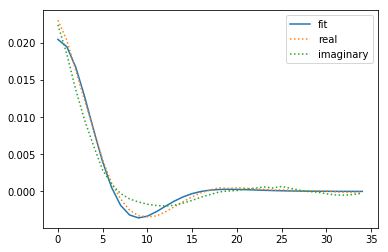

In [10]:
corr_real, r  = radial_component(np.real(m))
corr_imag, r  = radial_component(np.imag(m))

plt.plot(r, mexican_hat_kernel(r[:,np.newaxis], 0, sigma=sigma_opt, alpha=alpha_opt), label='fit')

plt.plot(r, corr_real, label='real', linestyle=':')
plt.plot(r, corr_imag, label='imaginary', linestyle=':')
plt.legend()

In [6]:
gp = GaussianProcessOPM(size=size, prior_method='icd', prior_rank=200)

### Noise model

In [101]:
from sklearn.decomposition import FactorAnalysis

In [102]:
# as an initial estimate, we simply assume the whole signal is noise
C_init = np.zeros((n, n))
for R_i in R.reshape(N_cond, repetitions, -1):
    C_i = np.cov(R_i.T)
    C_init += C_i
    
C_init /= N_cond
C_init.shape
sigma = C_init

In [103]:
for i in range(5):
    
    mu_post = gp.fit(stimuli=V, responses=R, noise=sigma)
    
    z = R.reshape(N, n) - V.reshape(N, d) @ mu_post.reshape(d, n)

    fa = FactorAnalysis(n_components=10)
    fa.fit(z)
    sigma = fa.get_covariance()

In [104]:
G = fa.components_.T

In [105]:
D = np.diag(fa.noise_variance_)

## Gaussian Process Posterior

The covariance and mean of the Gaussian process posterior can be obtained as:

$ \Sigma_{post}^{-1} = K_m^{-1} + (\sum_i v_i v_i^T) \otimes \Sigma_{\epsilon}^{-1}$

$ \mu_{post} = \Sigma_{post} (\mathbb{I}_d \otimes \Sigma_{\epsilon}^{-1}) \sum_i v_i \otimes \mathbf{r}_i $

In [8]:
# first we optimize the prior parameters
gp.optimize(V, R)
gp.kernel_params

{'sigma': 2.3584546679295046, 'alpha': 1.690214197278074}

In [8]:
gp.fit_prior()

In [7]:
mu_post = gp.fit(stimuli=V, responses=R, noise=np.eye(n) * 0.1, verbose=True)

*** Estimating prior hyperparameters ***
{'sigma': 2.4924555249235336, 'alpha': 2.1239577461263277}
*** Fitting prior ***
*** Fitting posterior ***


In [10]:
gp.save(fname='pkl/synthetic_opm.pkl')

In [11]:
gp = GaussianProcessOPM.load(fname='pkl/synthetic_opm.pkl')
mu_post = gp.mu_post

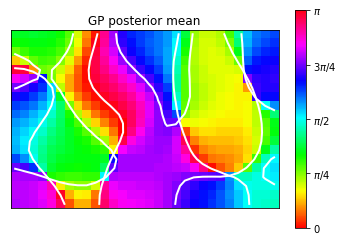

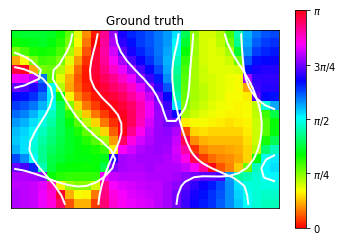

In [8]:
result = mu_post[0] + 1j * mu_post[1]
f, ax = plot_opm(result, title='GP posterior mean')

plt.show()

f, ax = plot_opm(m, title='Ground truth')

plt.show()